---

**Leaning NLP**(Natural Language Processing) By [Moussa JAMOR](https://github.com/JamorMoussa)

Github repository: [https://github.com/JamorMoussa/learn-NLP](https://github.com/JamorMoussa/learn-NLP)

Notebook Link: [https://github.com/JamorMoussa/learn-NLP/blob/main/Pytorch-for-NLP/PyTorch-Embedding-Module.ipynb](https://github.com/JamorMoussa/learn-NLP/blob/main/Pytorch-for-NLP/PyTorch-Embedding-Module.ipynb)

---

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import re
import matplotlib.pyplot as plt

### Get Text Data:

In [17]:
sentences = [
    "king is a man", 
    "The queen is a woman", 
    "queen is wife of the king",
    "man can be a king",
    "woman can be a queen",
    "king is not queen and queen is not king"
]


### Build The vocabulary:

In [18]:
text = " ".join(sentences).lower()

In [19]:
vocab = {word: i for i, word in enumerate(set(text.split()))}
vocab_size = len(vocab)

In [20]:
vocab_size

13

In [21]:
context = []
target = []
words = text.split()
for i in range(1, len(words) - 1):
    target.append(vocab[words[i]])
    context.append([vocab[words[i-1]], vocab[words[i+1]]])    

### Build Dataset: 

In [22]:
class TextDataSet(Dataset):

    def __init__(self):

        self.X: torch.Tensor = torch.tensor(context)
        self.y: torch.Tensor = torch.tensor(target)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index: int) -> tuple[torch.Tensor, torch.Tensor]:
        return self.X[index], self.y[index]

In [23]:
dataset = TextDataSet()

In [24]:
dataLoader = DataLoader(dataset, batch_size=1, shuffle=True)

### Build The CBoW Model: 

In [25]:
class Word2Vec(nn.Module):

    def __init__(self, vocab_size, emb_size):
        super(Word2Vec, self).__init__()

        self.emb_layer = nn.Embedding(vocab_size, emb_size)
        self.l1 = nn.Linear(emb_size, vocab_size)

    def forward(self, context): 
        out = self.emb_layer(context).sum(dim=1).reshape(1, -1)
        return self.l1(out)    

In [26]:
model = Word2Vec(vocab_size, 2)

In [27]:
model.emb_layer(torch.tensor([0, 2])).sum(axis=1).reshape(1, -1)

tensor([[-2.3071,  0.1871]], grad_fn=<ViewBackward0>)

In [28]:
model(torch.tensor([0 , 2]))

tensor([[ 0.8212,  1.0392, -0.7816,  1.7614, -1.7108, -0.7274,  0.1497, -2.1052,
         -0.0857,  0.0735, -0.1232, -0.2654,  1.3483]],
       grad_fn=<AddmmBackward0>)

In [29]:
criterion = nn.CrossEntropyLoss()
opt = optim.AdamW(model.parameters(), lr=0.001)

### Train the Model:

In [30]:
for epoch in range(1000):
    total_loss = 0
    
    for context, target in dataLoader:

        opt.zero_grad()

        pred = model(context)

        target_vec = torch.zeros(1, vocab_size)

        target_vec[0][int(target)] = 1
        
        loss = criterion(pred, target_vec)

        loss.backward()
            
        opt.step()

        total_loss += loss.item()

    if epoch %50 ==0:
        print(f"epoch {epoch} with Loss: ", total_loss)

epoch 0 with Loss:  92.96073460578918
epoch 50 with Loss:  71.3580482006073
epoch 100 with Loss:  61.504278898239136
epoch 150 with Loss:  54.518056750297546
epoch 200 with Loss:  50.07727500796318
epoch 250 with Loss:  46.636629581451416
epoch 300 with Loss:  43.794466346502304
epoch 350 with Loss:  41.39121854305267
epoch 400 with Loss:  39.210152462124825
epoch 450 with Loss:  37.24975594878197
epoch 500 with Loss:  35.60017128288746
epoch 550 with Loss:  34.12724854052067
epoch 600 with Loss:  32.929014310240746
epoch 650 with Loss:  31.823709182441235
epoch 700 with Loss:  30.971777841448784
epoch 750 with Loss:  30.117988534271717
epoch 800 with Loss:  29.414170883595943
epoch 850 with Loss:  28.779152005910873
epoch 900 with Loss:  28.282449442893267
epoch 950 with Loss:  27.775338668376207


In [31]:
def word_vec(word):
    return model.emb_layer(torch.tensor(vocab[word]))

In [32]:
king = word_vec("king")
king

tensor([ 1.4755, -2.9593], grad_fn=<EmbeddingBackward0>)

In [33]:
man = word_vec("man")
man

tensor([-2.6557, -1.2211], grad_fn=<EmbeddingBackward0>)

In [34]:
woman = word_vec("woman")
woman

tensor([-1.4526, -0.7874], grad_fn=<EmbeddingBackward0>)

In [35]:
queen = word_vec("queen")
queen

tensor([ 1.9939, -1.2944], grad_fn=<EmbeddingBackward0>)

In [36]:
k = queen + man - woman

In [37]:
q = word_vec("king")
q

tensor([ 1.4755, -2.9593], grad_fn=<EmbeddingBackward0>)

In [38]:
torch.dot(k, q)/(k.norm() * q.norm())

tensor(0.9994, grad_fn=<DivBackward0>)

In [39]:
array = torch.stack([king, man, woman, queen]).detach().numpy()

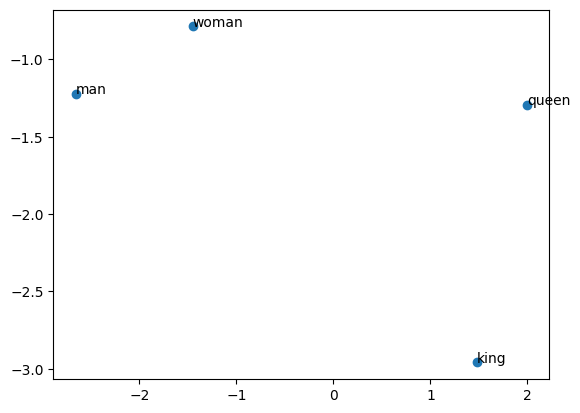

In [40]:
labels = ["king", "man", "woman", "queen"]

plt.scatter(array[:, 0], array[:, 1])

for i, label in enumerate(labels):
    plt.annotate(label, (array[i, 0], array[i, 1]))